### Multi AI Agents using LangGrapph and AstraDB

#### Setup and Initialisation

In [1]:
import os
from dotenv import load_dotenv
_ = load_dotenv()


try:
    api_key = os.getenv('GROQ_API_KEY') 
    
    if api_key:
        print("API KEY fetched Successfully!")
    else:
        print("Error in accessing the API KEY.")
except Exception as e:
    print(f"Error {e} occurred.")

API KEY fetched Successfully!


In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_astradb import AstraDBVectorStore
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\HP\Desktop\ML & DL\Gen AI Tutorial\for-github\.langgraph-agents\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## Documents to be vectorised
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

## Loading the Document's URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print("Length of the Documents: ", len(docs_list))
# docs_list


Length of the Documents:  3


In [4]:
## Documets list is Ready! 
## Next is to split the Docs (texts)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, 
    chunk_overlap=0
)

# text_splitter

docs_split = text_splitter.split_documents(docs_list)
print("Length of the Texts: ", len(docs_split))
docs_split[:5]

Length of the Texts:  88


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [5]:
import sentence_transformers
embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
embeddings

c:\Users\HP\Desktop\ML & DL\Gen AI Tutorial\for-github\.langgraph-agents\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [7]:
## Set Up Credentials of the Astra DB
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:"
ASTRA_DB_API_ENDPOINT = "https://"


vector_store = AstraDBVectorStore(
    collection_name = 'langgraph_astra',
    embedding=embeddings, 
    token=ASTRA_DB_APPLICATION_TOKEN, 
    api_endpoint=ASTRA_DB_API_ENDPOINT
)

print("Astra Vector Store has been configured.")

Astra Vector Store has been configured.


In [8]:
vector_store.add_documents(docs_split)
print("Inserted %i headline." % len(docs_split))

Inserted 88 headline.


In [9]:
astra_vector_index = VectorStoreIndexWrapper(vectorstore=vector_store)
astra_vector_index

VectorStoreIndexWrapper(vectorstore=<langchain_astradb.vectorstores.AstraDBVectorStore object at 0x00000204A09C6210>)

In [10]:
retriever = vector_store.as_retriever()
retriever

VectorStoreRetriever(tags=['AstraDBVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_astradb.vectorstores.AstraDBVectorStore object at 0x00000204A09C6210>, search_kwargs={})

In [11]:
retriever.invoke("What is agent", ConsistencyLevel="LOCAL_ONE")

[Document(id='667cf59270c24698bb022c517bc8240a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, ther

In [12]:
### Router 

## Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal['vectorstore', 'wiki_search', 'arxiv_search'] = Field(
        ..., 
        description="Given a user question choose to route it to wikipedia, a vectorstores or Arxiv.", 
    )

In [13]:
llm = ChatGroq(api_key=api_key, model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)
structured_llm_router

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000204BFDE52B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000204C291EDE0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevant datasource.', 'parameters': {'type': 'object', 'properties': {'datasource': {'description': 'Given a user question choose to route it to wikipedia, a vectorstores or Arxiv.', 'enum': ['vectorstore', 'wiki_search', 'arxiv_search'], 'type': 'string'}}, 'required': ['datasource']}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'RouteQuery'}}}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.RouteQuery'>])

In [31]:
## Prompt

system = """ 
You are an expert at routing a user question to a vectorstore, wikipedia or arxiv. 
The vectorstore contains document related to agents, prompt engineering and adversarial attacks.
Use the vectorstores for the questions on these topics. Otherwise, use wiki-search or arxiv.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system), 
        ("human", "{question}"), 
    ]
)

question_route = route_prompt | structured_llm_router

print(question_route.invoke({"question": "Who is Virat Kohli?"}))

print(question_route.invoke({"question": "What are the types of agent memory?"}))

print(question_route.invoke({"question": "What are the latest advancements in quantum computing as of 2023?"}))


datasource='wiki_search'
datasource='vectorstore'
datasource='arxiv_search'


In [32]:
## Working with the Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [33]:
## Graph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """ 
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM Generation
        documents: List of Documents
    """

    question: str
    generation: str
    documents: List[str]

In [34]:
from langchain.schema import Document

def retrieve(state):
    """ 
    Retrieve documents

    Args:
        state(dict): The current graph state

    Returns:
        state(dict): New key added to state, document that contains retrieved documents
    """

    print("---RETRIEVE---")
    question = state['question']

    ## Retrieval 
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [35]:
def wiki_search(state):
    """ 
    Wiki search based on the re-phrased question.

    Args:
        state(dict): The current graph state
    
    Returns:
        state(dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO---")
    question = state['question']
    print(question)

    ## Wiki Search
    docs = wiki.invoke({"query": question})

    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [36]:
def arxiv_search(state):
    """ 
    Arxiv search based on the re-phrased question.

    Args:
        state(dict): The current graph state
    
    Returns:
        state(dict): Updates documents key with appended Arxiv results
    """
    print("---ARXIV SEARCH---")
    question = state['question']
    print(question)

    # Perform Arxiv search
    docs = arxiv.invoke({"query": question})
    arxiv_results = Document(page_content=docs)

    return {"documents": arxiv_results, "question": question}

In [37]:
## Edges

def route_question(state):
    """ 
    Route question to wiki search or RAG

    Args:
        state(dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state['question']
    source = question_route.invoke({"question": question})

    if source.datasource == 'wiki_search':
        print("---Route Question to Wiki Search---")
        return "wiki_search"

    elif source.datasource == 'vectorstore':
        print("---Route Question to RAG---")
        return "vectorstore"

    elif source.datasource == 'arxiv_search':
        print("---Route Question to Arxiv Search---")
        return "arxiv_search"

In [38]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

## Define the Nodes
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("arxiv_search", arxiv_search)


## Build Graph
workflow.add_conditional_edges(
    START, 
    route_question, 
    {
        "wiki_search": "wiki_search", 
        "vectorstore": "retrieve",
        "arxiv_search": "arxiv_search",
    },
)

workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)
workflow.add_edge("arxiv_search", END)

app = workflow.compile()

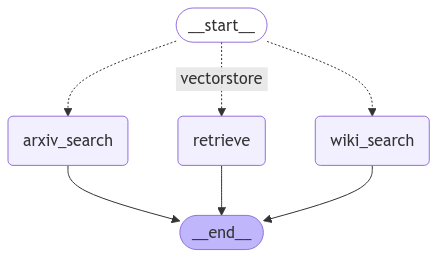

In [39]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
# pprint(value['documents'][0].dict()['metadata']['description'])
pprint(value['documents'])

---ROUTE QUESTION---
---Route Question to RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
[Document(id='667cf59270c24698bb022c517bc8240a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and 

In [41]:
from pprint import pprint

# Run
inputs = {
    "question": "Who is Virat Kohli?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---Route Question to Wiki Search---
---wikipedia---
---HELLO---
Who is Virat Kohli?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content="Page: Career of Virat Kohli\nSummary: Virat Kohli's senior career began when he made his debut in List A cricket, playing against Services in the Ranji One-Day Trophy, but he did not have the opportuni")


In [42]:
from pprint import pprint

# Run
inputs = {
    "question": "What are the latest advancements in quantum computing as of 2023?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---Route Question to Arxiv Search---
---ARXIV SEARCH---
What are the latest advancements in quantum computing as of 2023?
"Node 'arxiv_search':"
'\n---\n'
Document(metadata={}, page_content='Published: 2024-10-02\nTitle: New Tests of Equal Forecast Accuracy for Factor-Augmented Regressions with Weaker Loadings\nAuthors: Luca Margaritella, Ovidijus Stauskas\nSummary: We provide the theoretica')
